### Meta Labeling II

Meta Labeling은 Marcos Lopez de Prado(2018)가 저서 Advances in Financial Machine Learning에서 제안한 모형으로, labeling문제에 직면한 금융 머신러닝 프로젝트에 적절한 방법을 제시한다. 다음과 같은 논리로 이뤄진다

1. Feature 준비 : 자산에 대한 가격 데이터, technical feature등을 포함한 feature matrix를 준비한다
2. Primary Model : 자산의 가격이 상승할지, 하강할지 판단하는 모형이다. 여기에는 자신만의 판단 기준을 내세울 수 있으며, 때로는 애널리스트의 판단이 될 수 있다
3. Secondary Model : Primary Model에서 나온 정보를 가지고 거래를 집행할지, 하지 않을지를 판단하는 모형이다. 거래 집행 유무만 판단하므로 이진 분류 문제가 된다

오늘은 13주차에 이어서 technical feature를 이용해 간단한 이동평균 매수매도 전략을 Primary Model로 제작한 후, Ensemble Model을 활용하여 Secondary Model을 제작해 매매 의사결정 모형을 만드는 것을 목표로 한다

#### 1. Data Import

아래의 library를 활용해 Apple의 가격 시계열을 불러오자. 한국은 공매도 집행이 금지되었으므로 고려하지 않는다. 기간은 2000년 1월 1일부터 12월 22일까지로 지정한다. 시계열이므로 정상성을 위해 로그 차분을 진행한다

In [1]:
import yfinance as yf
import pandas as pd
import numpy as np

start_date = '2000-01-01'
end_date = '2023-12-23'

apple = yf.download('AAPL', start = start_date, end = end_date)
apple_ret = np.log(apple.Close / apple.Close.shift(1)).dropna()
apple_ret.head()

[*********************100%%**********************]  1 of 1 completed


Date
2000-01-04   -0.088077
2000-01-05    0.014527
2000-01-06   -0.090514
2000-01-07    0.046281
2000-01-10   -0.017744
Name: Close, dtype: float64

#### 2. Fractionally Differentiated Features

Prado(2018)는 저서 Advances in Financial Machine Learning을 통해 시장의 장기 기억을 담고 있는 시계열의 경우 Machine Learning 학습에 도움이 된다고 주장하였다

`IntegratedSeries.py`의 함수를 이용하여 원 시계열 데이터에 0.6차분을 수행하라. 사용 방법은 7주차 내용을 참고하라

In [2]:
import IntegratedSeries as IS
import statsmodels.api as sm

In [3]:
apple_d = IS.fracDiff_FFD(apple[['Close']], 0.6)

/Users/junghunlee/Desktop/Pycharm/QUANTIFI/week15 Ensemble Models/IntegratedSeries.py:29: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_ = pd.Series()


In [4]:
apple['fracdiff'] = apple_d

#### 3. Technical Features

`ta` library에는 다양한 기술적 분석들에 사용 가능한 feature를 제작해 준다. ta library를 활용하여 다음과 같은 feature를 만들어 주도록 한다

- money flow index : window = 20
- on balance volume : window = 20
- rsi : window = 20
- bollinger band : window = 20, window_dev = 1
- volume weighted average price : window = 20
- tsi indicator : window_fast = 13, window_slow = 25

In [5]:
from ta.volatility import BollingerBands
from ta.volume import money_flow_index, on_balance_volume
from ta.momentum import rsi
from ta.volume import volume_weighted_average_price
from ta.momentum import tsi

indicator_bb = BollingerBands(close = apple["Close"], window = 20, window_dev = 1)

apple['bb_bbm'] = indicator_bb.bollinger_mavg()
apple['bb_bbh'] = indicator_bb.bollinger_hband()
apple['bb_bbl'] = indicator_bb.bollinger_lband()

apple['mfi'] = money_flow_index(high = apple.High, 
                                low = apple.Low, 
                                close = apple.Close, 
                                volume = apple.Volume,
                                window = 20)
apple['obv'] = on_balance_volume(close = apple.Close, 
                                   volume = apple.Volume)
apple['rsi'] = rsi(close = apple.Close, window = 21)
apple['return'] = apple_ret
apple['vwap'] = volume_weighted_average_price(high = apple['High'],
                                              low = apple['Low'],
                                              close = apple['Close'],
                                              volume = apple['Volume'],
                                              window = 20)
apple['tsi'] = tsi(close = apple['Close'],
                   window_fast = 13,
                   window_slow = 15)

#### 4. Corwin Schultz Spread

10주차의 `MicroStructure.py`를 이용하여 corwin schultz spread를 계산하라. 사용방법은 10주차의 내용을 참고하도록 한다

In [6]:
import MicroStructure as ms

spread = ms.CorwinSchultz(high = apple.High, low = apple.Low)

In [7]:
cs_estimator = spread.corwin_schultz_estimator(window = 20)
cs_estimator.dropna().head()

Date
2000-02-01    0.004752
2000-02-02    0.060278
2000-02-03    0.072427
2000-02-04    0.013942
2000-02-07    0.000000
Name: Spread, dtype: float64

In [8]:
apple['corwin_schultz'] = cs_estimator

In [9]:
apple.dropna(inplace = True)

#### 5. Primary Modeling

Primary Model에서는 방향만을 추정한다. 여기서는 Bollinger Band전략을 사용하여 가격이 상승할 것인지, 하락할 것인지 labeling을 하자. 여기서 상승은 1, 하락은 -1, 횡보상태는 0으로 labeling한다

In [10]:
apple['label'] = 0
apple.loc[(apple['Close'] > apple['bb_bbh']), 'label'] = 1
apple.loc[(apple['Close'] < apple['bb_bbl']), 'label'] = -1
apple.head()

,Open,High,Low,Close,Adj Close,Volume,fracdiff,bb_bbm,bb_bbh,bb_bbl,mfi,obv,rsi,return,vwap,tsi,corwin_schultz,label
Date,,,,,,,,,,,,,,,,,,
2002-05-10,0.433750,0.433750,0.410357,0.416429,0.352998,235396000,-0.008617,0.431545,0.448236,0.414853,51.141905,-3680986400,46.762252,-0.036626,0.435058,-9.516220,0.000000,0
2002-05-13,0.420000,0.430179,0.409643,0.427500,0.362383,265608000,0.010881,0.430598,0.446952,0.414244,50.728989,-3415378400,49.700168,0.026238,0.433914,-7.497196,0.000000,0
2002-05-14,0.436607,0.458571,0.432500,0.457321,0.387662,526506400,0.035424,0.430482,0.446637,0.414328,49.845975,-2888872000,56.491004,0.067431,0.432820,-0.355367,0.000000,1
2002-05-15,0.453036,0.463929,0.443571,0.451429,0.382667,335826400,0.010873,0.429741,0.444519,0.414963,49.210677,-3224698400,54.951900,-0.012967,0.431957,3.516093,0.000000,1
2002-05-16,0.447500,0.454464,0.441964,0.450179,0.381608,227052000,0.009276,0.429563,0.444068,0.415057,50.857085,-3451750400,54.620401,-0.002773,0.431246,6.074729,0.020592,1


#### 6. Meta Labeling

Secondary Model은 Primary Model에서 나온 방향을 이용해 거래의 실행 여부만을 평가한다. 3개의 레이블[-1, 0, 1]을 이진 분류 모형[0, 1]으로 다시 labeling을 진행한다. 이 과정을 Meta Labeling이라고 한다

In [11]:
apple['meta_label'] = 0
apple.loc[(apple['label'] == 1) | (apple['label'] == -1), 'meta_label'] = 1
apple.head()

,Open,High,Low,Close,Adj Close,Volume,fracdiff,bb_bbm,bb_bbh,bb_bbl,mfi,obv,rsi,return,vwap,tsi,corwin_schultz,label,meta_label
Date,,,,,,,,,,,,,,,,,,,
2002-05-10,0.433750,0.433750,0.410357,0.416429,0.352998,235396000,-0.008617,0.431545,0.448236,0.414853,51.141905,-3680986400,46.762252,-0.036626,0.435058,-9.516220,0.000000,0,0
2002-05-13,0.420000,0.430179,0.409643,0.427500,0.362383,265608000,0.010881,0.430598,0.446952,0.414244,50.728989,-3415378400,49.700168,0.026238,0.433914,-7.497196,0.000000,0,0
2002-05-14,0.436607,0.458571,0.432500,0.457321,0.387662,526506400,0.035424,0.430482,0.446637,0.414328,49.845975,-2888872000,56.491004,0.067431,0.432820,-0.355367,0.000000,1,1
2002-05-15,0.453036,0.463929,0.443571,0.451429,0.382667,335826400,0.010873,0.429741,0.444519,0.414963,49.210677,-3224698400,54.951900,-0.012967,0.431957,3.516093,0.000000,1,1
2002-05-16,0.447500,0.454464,0.441964,0.450179,0.381608,227052000,0.009276,0.429563,0.444068,0.415057,50.857085,-3451750400,54.620401,-0.002773,0.431246,6.074729,0.020592,1,1


#### 7. Secondary Modeling

Meta Label을 target으로 지정하고, 2번에서 지정한 technical feature들을 이용하여 이진 분류 모형을 수행하라. 즉, feature matrix에는 아래와 같은 데이터들이 들어간다

- fractionally differenctiated features
- money flow index
- on balance volume
- RSI
- TSI
- VWAP
- log return
- corwin schultz spread
- meta label (target)

여기서, Bollinger Band 관련 feature들은 labeling에 사용되었으므로 고려하지 않는다

모형의 검증을 위해 test data는 0.2로 지정하고 shuffle = False로 지정한다

In [12]:
matrix = apple[['fracdiff','mfi','obv','rsi','return','vwap','tsi','corwin_schultz','meta_label']]
matrix.head()

,fracdiff,mfi,obv,rsi,return,vwap,tsi,corwin_schultz,meta_label
Date,,,,,,,,,
2002-05-10,-0.008617,51.141905,-3680986400,46.762252,-0.036626,0.435058,-9.516220,0.000000,0
2002-05-13,0.010881,50.728989,-3415378400,49.700168,0.026238,0.433914,-7.497196,0.000000,0
2002-05-14,0.035424,49.845975,-2888872000,56.491004,0.067431,0.432820,-0.355367,0.000000,1
2002-05-15,0.010873,49.210677,-3224698400,54.951900,-0.012967,0.431957,3.516093,0.000000,1
2002-05-16,0.009276,50.857085,-3451750400,54.620401,-0.002773,0.431246,6.074729,0.020592,1


In [13]:
from sklearn.model_selection import train_test_split

X = matrix.drop('meta_label', axis = 1)
y = matrix['meta_label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, shuffle = False)

**7.1 RandomForest Classifier**

Secondary Model로 Random Forest Classifier를 사용하고 성능을 평가하라. Hyper Parameter는 다음과 같이 지정한다

```
n_estimators = 1000
sample_weights = 'balanced_subsample'
criterion = 'entropy'
ccp_alpha = 0.001
random_state = 42
```

In [14]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(
    n_estimators = 1000,
    criterion = 'entropy', 
    random_state = 42,
    class_weight = 'balanced_subsample', 
    ccp_alpha = 0.001,
    )
model = rf.fit(X_train, y_train)

In [15]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc

y_prob = rf.predict_proba(X_test)[:, 1]
y_pred = rf.predict(X_test)
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')

Accuracy: 0.7410468319559229


In [16]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.66      0.64      0.65       412
           1       0.78      0.80      0.79       677

    accuracy                           0.74      1089
   macro avg       0.72      0.72      0.72      1089
weighted avg       0.74      0.74      0.74      1089


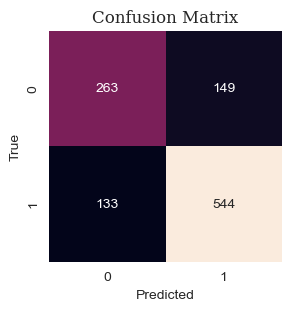

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize = (3, 3))
sns.heatmap(cm, annot = True, fmt = 'd', cbar = False)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix', fontsize = 12, fontfamily = 'Serif')
plt.show()

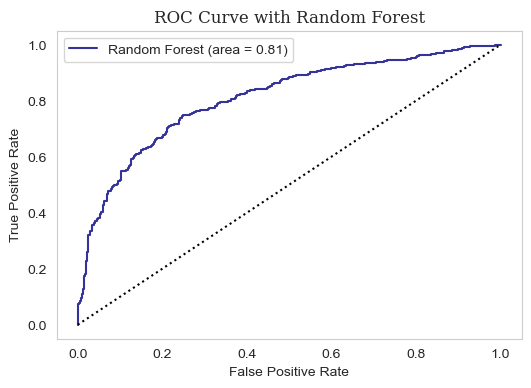

In [18]:
y_prob = rf.predict_proba(X_test)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize = (6, 4))
plt.plot(fpr, tpr, label = 'Random Forest (area = {:.2f})'.format(roc_auc), color = 'navy', alpha = 0.8)
plt.plot([0, 1], [0, 1], 'k:')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve with Random Forest', fontsize = 12, fontfamily = 'Serif')
plt.grid(False)
plt.legend()
plt.show()

**7.2 Ada Boosting**

동일한 작업을 AdaBoosting을 통해 확인하라. 단, 기초 모형은 Decision Tree를 사용하고, Hyper Parameter는 다음과 같이 지정하도록 한다

**Estimator : Tree**
```
    max_depth = 1,
    criterion = 'entropy',
    class_weight = 'balanced',
    random_state = 42
```

**Adaboost**
```
    n_estimators = 1000,
    random_state = 42
```

In [24]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

tree = DecisionTreeClassifier(
    criterion = 'entropy',
    class_weight = 'balanced',
    random_state = 42
)
adaboost = AdaBoostClassifier(
    tree,
    n_estimators = 1000,
    random_state = 42
)

In [25]:
adaboost.fit(X_train, y_train)

AdaBoostClassifier(estimator=DecisionTreeClassifier(class_weight='balanced',
                                                    criterion='entropy',
                                                    random_state=42),
                   n_estimators=1000, random_state=42)

In [26]:
y_prob = adaboost.predict_proba(X_test)[:, 1]
y_pred = adaboost.predict(X_test)
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')

Accuracy: 0.6409550045913682


In [27]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.53      0.42      0.47       412
           1       0.69      0.77      0.73       677

    accuracy                           0.64      1089
   macro avg       0.61      0.60      0.60      1089
weighted avg       0.63      0.64      0.63      1089


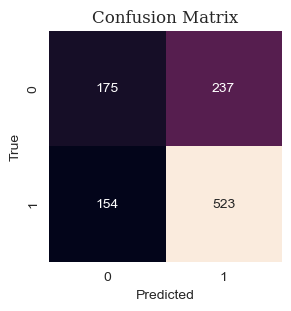

In [28]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize = (3, 3))
sns.heatmap(cm, annot = True, fmt = 'd', cbar = False)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix', fontsize = 12, fontfamily = 'Serif')
plt.show()

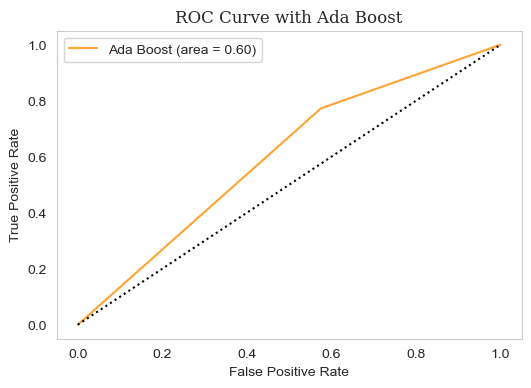

In [29]:
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize = (6, 4))
plt.plot(fpr, tpr, label = 'Ada Boost (area = {:.2f})'.format(roc_auc), color = 'darkorange', alpha = 0.8)
plt.plot([0, 1], [0, 1], 'k:')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve with Ada Boost', fontsize = 12, fontfamily = 'Serif')
plt.grid(False)
plt.legend()
plt.show()

**7.3 Gradient Boosting**

주어진 문제를 Gradient Boosting을 활용해 추정하자. Hyper Parameter는 아래와 같이 지정한다

```
    n_estimators = 1000, 
    learning_rate = 1.0, 
    max_depth = 1, 
    random_state = 42
```

In [34]:
from sklearn.ensemble import GradientBoostingClassifier

gradient = GradientBoostingClassifier(
    n_estimators = 1000, 
    learning_rate = 1.0, 
    max_depth = 6, 
    random_state = 42
)

In [35]:
gradient.fit(X_train, y_train)

GradientBoostingClassifier(learning_rate=1.0, max_depth=6, n_estimators=1000,
                           random_state=42)

In [36]:
y_prob = gradient.predict_proba(X_test)[:, 1]
y_pred = gradient.predict(X_test)
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')

Accuracy: 0.6326905417814509


In [37]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.51      0.76      0.61       412
           1       0.79      0.55      0.65       677

    accuracy                           0.63      1089
   macro avg       0.65      0.66      0.63      1089
weighted avg       0.69      0.63      0.64      1089


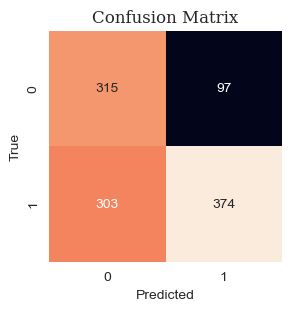

In [38]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize = (3, 3))
sns.heatmap(cm, annot = True, fmt = 'd', cbar = False)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix', fontsize = 12, fontfamily = 'Serif')
plt.show()

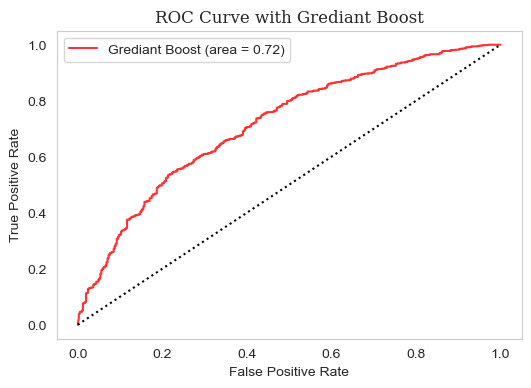

In [39]:
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize = (6, 4))
plt.plot(fpr, tpr, label = 'Grediant Boost (area = {:.2f})'.format(roc_auc), color = 'red', alpha = 0.8)
plt.plot([0, 1], [0, 1], 'k:')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve with Grediant Boost', fontsize = 12, fontfamily = 'Serif')
plt.grid(False)
plt.legend()
plt.show()

**7.4 CatBoosting**

주어진 문제를 CatBoost를 활용해 예측해 보자. 아래의 Hyper Parameter를 사용하고, Sample Weights는 Random Forest에서 사용했던 balanced_subsample과 동일한 기능을 하도록 조정한다

```
    class_weights = class_weights,
    n_estimators = 1000,
    loss_function = 'Logloss',
    random_state = 42,
    learning_rate = 0.1,
    verbose = 0
```

In [40]:
from sklearn.utils.class_weight import compute_class_weight

classes = np.unique(y_train)
weights = compute_class_weight(
    class_weight = 'balanced', 
    classes = classes, 
    y = y_train
)
class_weights = dict(zip(classes, weights))

In [41]:
from catboost import CatBoostClassifier
cat = CatBoostClassifier(
    class_weights = class_weights,
    n_estimators = 1000,
    loss_function = 'Logloss',
    random_state = 42,
    learning_rate = 0.1,
    verbose = 0
)

In [42]:
cat.fit(X_train, y_train)

In [43]:
y_prob = cat.predict_proba(X_test)[:, 1]
y_pred = cat.predict(X_test)
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')

Accuracy: 0.7144168962350781


In [44]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.64      0.57      0.60       412
           1       0.75      0.80      0.78       677

    accuracy                           0.71      1089
   macro avg       0.70      0.69      0.69      1089
weighted avg       0.71      0.71      0.71      1089


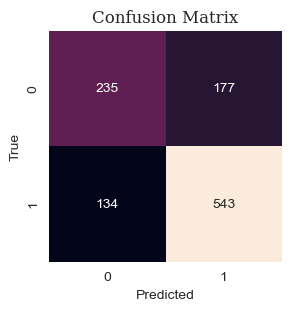

In [45]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize = (3, 3))
sns.heatmap(cm, annot = True, fmt = 'd', cbar = False)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix', fontsize = 12, fontfamily = 'Serif')
plt.show()

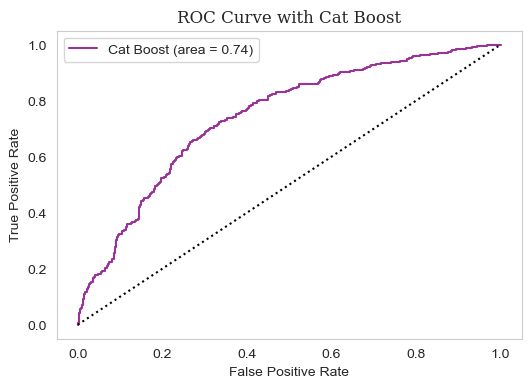

In [46]:
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize = (6, 4))
plt.plot(fpr, tpr, label = 'Cat Boost (area = {:.2f})'.format(roc_auc), color = 'purple', alpha = 0.8)
plt.plot([0, 1], [0, 1], 'k:')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve with Cat Boost', fontsize = 12, fontfamily = 'Serif')
plt.grid(False)
plt.legend()
plt.show()

#### 8. Compare Results

추정기간의 성능을 비교해 보자. 매매 기회를 최대한 많이 잡아내기 위해서는(실제 1 중에서 최대한 많이 잡아내는 것) 어떤 모형을 쓰는 것이 가장 효율적인가?